# Sugges_

One of the strategies to improve user experience is to provide user with hints, or, otherwise, to autocomplete his queries. Let's consider 'suggest'.

Today we will practice generating suggestions using [Trie](https://en.wikipedia.org/wiki/Trie) data structure (prefix tree), see the example below.

The **Trie** data structure is a tree-like data structure used for storing a dynamic set of strings. It is commonly used for efficient retrieval and storage of keys in a large dataset. The structure supports operations such as insertion, search, and deletion of keys, making it a valuable tool in fields like computer science and information retrieval.

A Trie consists of nodes connected by edges. Each node represents a character or a part of a string. The root node, the starting point of the Trie, represents an empty string. Each edge emanating from a node signifies a specific character. The path from the root to a node represents the prefix of a string stored in the Trie.

![image](https://www.ritambhara.in/wp-content/uploads/2017/05/Screen-Shot-2017-05-01-at-4.01.38-PM.png)

Plan of this lesson:

1. Build Trie based on real search query data, provided by AOL company;
2. Generate suggestion based on a trie;
3. Measure suggestion speed;

## 0. Install Trie data structure support

You are free to use any library implementation of Trie, as well as the one we suggest (read the docs before asking any questions!): https://github.com/google/pygtrie

In [13]:
!pip install pygtrie

## 1. Build a trie upon a dataset

### 1.1. Read the dataset

Download the [dataset](https://github.com/IUCVLab/information-retrieval/tree/main/datasets/aol) (we provide only the first part of the original data for simplicity (~3.5 mln queries)).

Explore the data, see readme file. Load the dataset. Pass the assert.

In [91]:
import pandas as pd

aol_data = None

#TODO: Read the dataset, e.g. as pandas dataframe
aol_data = pd.read_csv('./user-ct-test-collection-01.txt', delimiter='\t')
aol_data.dropna(subset=["Query"], inplace=True)

In [92]:
aol_data.head()

,AnonID,Query,QueryTime,ItemRank,ClickURL
0,142,rentdirect.com,2006-03-01 07:17:12,NaN,NaN
1,142,www.prescriptionfortime.com,2006-03-12 12:31:06,NaN,NaN
2,142,staple.com,2006-03-17 21:19:29,NaN,NaN
3,142,staple.com,2006-03-17 21:19:45,NaN,NaN
4,142,www.newyorklawyersite.com,2006-03-18 08:02:58,NaN,NaN


### 1.1.1. Tests

In [96]:
assert aol_data.shape[0] == 3558238, "Dataset size does not match"

### 1.2. Build a Trie

We want a suggest function to be **non-sensitive to stop words** because we don't want to upset the users if they confuses/omits prepositions. Consider *"public events in Innopolis"* vs *"public events at Innopolis"* or *"public events Innopolis"* - they all mean the same.

Build a Trie based on the dataset, **storing query statistics such as query _frequency_, urls and ranks in the nodes**. Some queries may have no associated urls, others may have multiple ranked urls. Think of the way to store this information.

Pass the asserts.

In [99]:
stops = set('a on at of to is from for and with using the in &'.split())

In [107]:
class Node():
    def __init__(self, query, url, rank):
        self.frequency = 1
        self.init = query
        self.filtered = None
        self.urls = []
        self.ranks = []
        self.update(url, rank)

    def update(self, url, rank):
        self.frequency += 1
        if url:
            self.urls.append(url)
            self.ranks.append(rank)

def filterStopWords(query, stops):
    query = query.lower()
    filtered = ''
    for word in query.split(' '):
        if word not in stops:
            filtered += word + ' '
    filtered = filtered.rstrip()
    return filtered

In [102]:
import pygtrie
import pandas as pd
from tqdm import tqdm
import numpy as np

aol_trie = pygtrie.CharTrie()

for i in tqdm(aol_data.index):
    # remove stop words and extra spaces in a query
    if aol_data['Query'][i]:
        filtered = filterStopWords(aol_data['Query'][i], stops)
        node = aol_trie.get(filtered, {})
        if node:
            node.update(aol_data['ClickURL'][i], aol_data['ItemRank'][i])
        else:
            node = Node(aol_data['Query'][i], aol_data['ClickURL'][i], aol_data['ItemRank'][i])
        aol_trie[filtered] = node
        node.filtered = filtered

100%|██████████| 3558238/3558238 [06:38<00:00, 8918.16it/s] 


### 1.2.1. Tests

In [104]:
# test trie
bag = []
for key, val in aol_trie.iteritems("sample q"):
    print(key, '~', val)

    #NB: here we assume you store urls in a property of list type. But you can do something different.
    bag += val.urls

    assert "sample question" in key, "All examples have `sample question` substring"
    assert key[:len("sample question")] == "sample question", "All examples have `sample question` starting string"

for url in ["http://www.surveyconnect.com", "http://www.custominsight.com",
            "http://jobsearchtech.about.com", "http://www.troy.k12.ny.us",
            "http://www.flinders.edu.au", "http://uscis.gov"]:
    assert url in bag, "This url should be in a try"

sample question surveys ~ <__main__.Node object at 0x7c1b58dd7e50>
sample questions immigration interview ~ <__main__.Node object at 0x7c1ba7836cb0>
sample questions interview ~ <__main__.Node object at 0x7c1ba78376a0>
sample questions family interview ~ <__main__.Node object at 0x7c1ba7837f40>
sample questions sociology race ethnicity ~ <__main__.Node object at 0x7c1ba77c1d20>
sample questions biology ~ <__main__.Node object at 0x7c1b964d4d60>
sample questions us citizenship test ~ <__main__.Node object at 0x7c1b94a2fa00>
sample questionarie teaching evaluation ~ <__main__.Node object at 0x7c1b7b518a60>
sample questionnaire teaching evaluation ~ <__main__.Node object at 0x7c1b7b518ac0>
sample questionnaire clinical research coordinators certification ~ <__main__.Node object at 0x7c1b93ed7dc0>


## 2. Non-sensitive to stop words

### 2.1. Write a suggest function which is non-sensitive to stop

Suggest options for user query based on Trie you just built.
Output results sorted by frequency, print query count for each suggestion. If there is an url available, print the url too. If multiple url-s are available, print the one with the highest rank (the less the better).

Pass the asserts.
Question for analysis: What is the empirical threshold for minimal prefix for suggest?

In [105]:
def complete_user_query(query: str, trie, top_k=5) -> list[str]:
    query = filterStopWords(query, stops)
    results = []

    try:
        for key, val in aol_trie.iteritems(query):
            results.append(val)
    except KeyError:
        # If prefix not found, continue with a longer prefix
        pass

    results = sorted(results, key=lambda x: x.frequency, reverse=True)[:top_k]
    to_return = [res.init for res in results]
    return to_return

In [108]:
inp = "trie"
print("Query:", inp)
print("Results:")
res = complete_user_query(inp, aol_trie)
print(res)

Query: trie
Results:
['tried and true tattoo', 'triest', 'triethanalomine', 'tried and failed', "tried and truechildren's consignment sale"]


### 2.1.1. Tests

In [109]:
assert res[0] == "tried and true tattoo"
assert res[1] == "triest" or res[1] == "triethanalomine"

print(complete_user_query("boys a girls club conyers", aol_trie, 10))

assert "boys and girls club of conyers georgia" \
            in complete_user_query("boys girls club conyers", aol_trie, 10), "Should be here"

['boys and girls club of conyers georgia']


## 3. Measure suggest speed ##

### 3.1. Full Trie test

Check how fast your search is working. Consider changing your code if it takes too long on average.

Sucess criterion:
- there is an average and a standard deviation for **multiple runs** of the given bucket.
- there is an average and a standard deviation for **multiple runs** of naive search in the unindexed dataset.

In [121]:
def naive_search(query, data, top_k=5):
    filtered_data = data[data["Query"].str.startswith(query)]
    return filtered_data["Query"].value_counts().index.tolist()[:top_k]

In [ ]:
import time
import numpy as np

inp_queries = ["inf", "the best ", "information retrieval", "sherlock hol", "carnegie mell",
               "babies r", "new york", "googol", "inter", "USA sta", "Barbara "]

print("Indexed search: ")
def indexed_run():
  for query in inp_queries:
    complete_user_query(query, aol_trie)

%timeit indexed_run()

print("Unindexed search: ")
def unindexed_run():
  for query in inp_queries:
    naive_search(query, aol_data)

%timeit unindexed_run()

## 4. Spellchecking

### 4.1. Add spellchecking to your suggest

Try to make your search results as close as possible. Compare top-5 results of each query with top-5 results for corrected.

You can use use [pyspellchecker](https://pypi.org/project/pyspellchecker/) `candidates()` call, or use any other spellchecker implementation.

In [112]:
!pip install pyspellchecker

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 84.1 MB/s eta 0:00:00


In [117]:
from collections import Counter

counter = Counter()

for query in aol_data['Query']:
    for word in query.split(' '):
        counter[word.lower()] += 1

from spellchecker import SpellChecker

spell = SpellChecker(distance=1)
spell.word_frequency._dictionary = counter
spell.word_frequency.remove_by_threshold(5)

In [118]:
from spellchecker import SpellChecker

def correct_word(word):
    if len(word) > 3:
        return spell.correction(word)
    return word

def complete_user_query_with_spellchecker(query, trie, top_k=5) -> list[str]:
    query = query.lower().split(' ')
    words = []
    for word in query:
        words.append(correct_word(word))

    print(words)
    correct_query = ' '.join(words)
    return complete_user_query(correct_query, trie, top_k)

### 4.1.1. Tests

In [119]:
inp_queries = ["inormation retrieval", "shelrock hol", "carnagie mell", "babis r", "Barrbara "]
inp_queries_corrected = ["information retrieval", "sherlock hol", "carnegie mell", "babies r", "Barbara "]

for q, qc in zip(inp_queries, inp_queries_corrected):
    assert  complete_user_query(qc, aol_trie, 5) == \
            complete_user_query_with_spellchecker(q, aol_trie, 5), "Assert {} and {} give different results".format(q, qc)

['information', 'retrieval']
['sherlock', 'hol']
['carnegie', 'mell']
['babies', 'r']
['barbara', '']


## 5. Assess how dataset size affect search time

Study the speed of the trie data structure in $\frac{1}{10}, \frac{1}{4}, \frac{1}{2}$, and full dataset.
- Sample the data at random.
- Plot the graph which shows how search time changes with dataset size.
- Compare aganist bruteforce.

100%|██████████| 3558238/3558238 [04:50<00:00, 12251.27it/s]


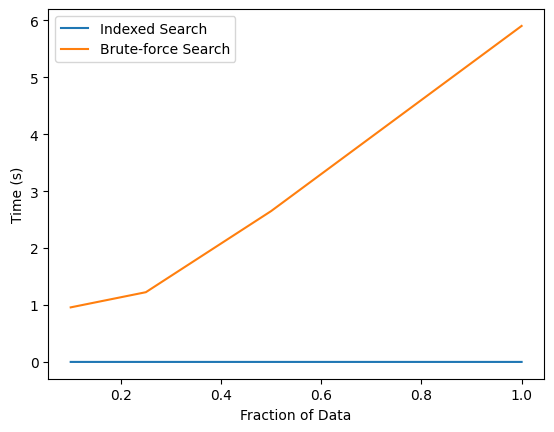

In [122]:
import matplotlib.pyplot as plt
import timeit
from tqdm import tqdm


def build_trie(part_data, stops):
    part_trie = pygtrie.CharTrie()

    for i in tqdm(part_data.index):
        filtered = filter(part_data['Query'][i], stops)
        if filtered:
            node = part_trie.get(filtered, {})
            if node:
                node.update(part_data['ClickURL'][i], part_data['ItemRank'][i])
            else:
                node = Node(part_data['Query'][i], part_data['ClickURL'][i], part_data['ItemRank'][i])
            part_trie[filtered] = node
            node.filtered = filtered

    return part_trie

def measure_time(func, *args):
    start_time = timeit.default_timer()
    func(*args)
    end_time = timeit.default_timer()
    return end_time - start_time


dataset_sizes = [1 / 10, 1 / 4, 1 / 2, 1]
time_indexed = []
time_bruteforce = []
for size in dataset_sizes:
    part_data = aol_data.sample(frac=size)

    part_trie = build_trie(part_data, stops)

    time_indexed.append(measure_time(complete_user_query, "information retrieval", part_trie, 5))
    time_bruteforce.append(measure_time(naive_search, "information retrieval", part_data, 5))

# plotting the results
plt.plot(dataset_sizes, time_indexed, label='Indexed Search')
plt.plot(dataset_sizes, time_bruteforce, label='Brute-force Search')
plt.xlabel('Dataset Sizes')
plt.ylabel('Time (s)')
plt.legend()
plt.show()

## 6. What if the query is in the middle?

Modify your code to suggest string even if the query is found **in the middle** of the text. Think about techniques you can borrow from our previous classes, e.g. about wildcard search.

E.g. `Semantic Parsing` in

```
3DCNN-DQN-RNN: A Deep Reinforcement Learning Framework for Semantic Parsing of Large-scale 3D Point Clouds
                                                           ~~~~~~~~~~~~~~~~
```

**NB**: Please extend you trie-based approach. Even if using `in` and regexp can give you same result, this is not a scalable approach, which we will not accept.

Pass the asserts.

In [124]:
def postfixes(query):
    words = filter(query.lower(), stops).split()
    return [' '.join(words[i:]) for i in range(len(words))]

In [125]:
import pygtrie

newtrie = None

def create_new_tree(aol_data):
    aol_trie = pygtrie.CharTrie()
    for i in tqdm(aol_data.index):
        for postfix in postfixes(aol_data['Query'][i]): # adding postfixes
            if postfix:
                query = aol_data['Query'][i]
                postfix_filtered = filter(postfix, stops)
                node = aol_trie.get(postfix_filtered, {})
                if query in node:
                    node[query].update(aol_data['ClickURL'][i], aol_data['ItemRank'][i])
                else:
                    node[query] = Node(aol_data['Query'][i], aol_data['ClickURL'][i], aol_data['ItemRank'][i])
                aol_trie[postfix_filtered] = node
                node[query].filtered = postfix_filtered
    return aol_trie

newtrie = create_new_tree(aol_data)

100%|██████████| 3558238/3558238 [15:44<00:00, 3768.31it/s]


In [131]:
def complete_user_query_with_spellchecker_and_middle(query, aol_trie, top_k=5, if_print=False) -> list[str]:
    query = filterStopWords(query, stops)
    results = []
    try:
        for key, val in aol_trie.iteritems(query):
            results.extend(list(val.values()))
    except KeyError:

        print('no results found')

    results = sorted(results, key=lambda x:x.frequency, reverse=True)[:top_k]
    toRet = []
    for res in results:
        toRet.append(res.init)
        print(f'Count {res.frequency}: {res.init}')
    return toRet

In [132]:
complete_user_query_with_spellchecker_and_middle(
            "adult movie", newtrie, 20)

Count 29: adult movies
Count 13: previews adult movies
Count 8: free adult movies
Count 6: virgin rape adult movies
Count 5: adult movie download
Count 4: drilled and filled adult movie
Count 4: faraway adult movie
Count 4: horny black mothers adult movie
Count 4: adult movie stars
Count 3: out of the ordinary & adult movie
Count 3: muy caliente adult movie
Count 3: pink slip adult movie
Count 3: adult movie downloads
Count 3: adult movie index
Count 3: ny city adult movie theaters
Count 3: free adult movie trailer
Count 3: adult movie trailers
Count 2: young and hungry adult movie
Count 2: ambition adult movie
Count 2: latina love songs adult movie


['adult movies',
 'previews adult movies',
 'free adult movies',
 'virgin rape adult movies',
 'adult movie download',
 'drilled and filled adult movie',
 'faraway adult movie',
 'horny black mothers adult movie',
 'adult movie stars',
 'out of the ordinary & adult movie',
 'muy caliente adult movie',
 'pink slip adult movie',
 'adult movie downloads',
 'adult movie index',
 'ny city adult movie theaters',
 'free adult movie trailer',
 'adult movie trailers',
 'young and hungry adult movie',
 'ambition adult movie',
 'latina love songs adult movie']

### 6.1.1. Tests

In [135]:
assert "ricky martin beach" in complete_user_query_with_spellchecker_and_middle(
            "martin beach", newtrie, 20)
assert "free adult movies" in  complete_user_query_with_spellchecker_and_middle(
            "adult movie", newtrie, 20)

Count 75: ricky martin beach
Count 29: adult movies
Count 13: previews adult movies
Count 8: free adult movies
Count 6: virgin rape adult movies
Count 5: adult movie download
Count 4: drilled and filled adult movie
Count 4: faraway adult movie
Count 4: horny black mothers adult movie
Count 4: adult movie stars
Count 3: out of the ordinary & adult movie
Count 3: muy caliente adult movie
Count 3: pink slip adult movie
Count 3: adult movie downloads
Count 3: adult movie index
Count 3: ny city adult movie theaters
Count 3: free adult movie trailer
Count 3: adult movie trailers
Count 2: young and hungry adult movie
Count 2: ambition adult movie
Count 2: latina love songs adult movie


## 7. Enrich your suggest with search results

Your users will be happy if at typing the query they see not only suggested queries, but also snippets of the answers to these queries!

Imagine you type "continental air", and the search engine suggests you "continental airlines" together with the URL and snippet kind of `"Continental Airlines was a major American airline founded in 1934 and eventually headquartered in Houston, Texas..."`, which you borrow from the search engine snippet. How can you add existing search enginge to your code? [One](https://yandex.com/dev/xml/doc/dg/task/quickstart.html), [two](https://docs.microsoft.com/en-us/bing/search-apis/bing-web-search/search-the-web), [three](https://searx.roughs.ru/), [four](https://serpapi.com/) ...

Improve your suggest. It should return a tuple of 3 instead of just a string. Your result is now `(query, text, url)`. Write your own tests which for the query `continental air` return among the results:
1. `query` = `continental airlines`.
2.
`Continental Airlines was a major American airline founded in 1934` in `text`.
3. `url` = `https://en.wikipedia.org/wiki/Continental_Airlines`.

In [136]:
!pip install duckduckgo-search

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 61.1 MB/s eta 0:00:00


In [137]:
from duckduckgo_search import DDGS

with DDGS() as ddgs:
    answer = list(ddgs.answers("information retrieval"))[0]
    print(answer)
    text = answer["text"]
    url = answer["url"]

{'icon': None, 'text': 'Information retrieval in computing and information science is the task of identifying and retrieving information system resources that are relevant to an information need. The information need can be specified in the form of a search query. In the case of document retrieval, queries can be based on full-text or other content-based indexing. Information retrieval is the science of searching for information in a document, searching for documents themselves, and also searching for the metadata that describes data, and for databases of texts, images or sounds. Automated information retrieval systems are used to reduce what has been called information overload. An IR system is a software system that provides access to books, journals and other documents; it also stores and manages those documents. Web search engines are the most visible IR applications.', 'topic': None, 'url': 'https://en.wikipedia.org/wiki/Information_retrieval'}


In [138]:
def complete_user_query_with_spellchecker_and_middle_with_snippets(query, trie, top_k=5) -> list[tuple]:
    with DDGS() as ddgs:
        answer = list(ddgs.answers(query))[0]
        print(answer)
        text = answer["text"]
        url = answer["url"]
        return answer, text, UnicodeTranslateError

In [139]:
complete_user_query_with_spellchecker_and_middle_with_snippets('continental airlines', aol_trie)

{'icon': None, 'text': 'Continental Airlines was a major airline in the United States that operated from 1934 until it merged with United Airlines in 2012. It had ownership interests and brand partnerships with several carriers. Continental started out as one of the smaller carriers in the United States, known for its limited operations under the regulated era that provided very fine, almost fancy, service against the larger majors in important point-to-point markets, the largest of which was Chicago/Los Angeles. However, deregulation in 1978 changed the competitive landscape and realities, as noted by Smithsonian Airline Historian R. E. G. Davies, "Unfortunately, the policies that had been successful for more than forty years under Six\'s cavalier style of management were suddenly laid bare as the cold winds of airline deregulation changed all the rules—specifically, the balance between revenues and expenditures." In 1981, Texas International Airlines acquired a controlling interest i

({'icon': None,
  'text': 'Continental Airlines was a major airline in the United States that operated from 1934 until it merged with United Airlines in 2012. It had ownership interests and brand partnerships with several carriers. Continental started out as one of the smaller carriers in the United States, known for its limited operations under the regulated era that provided very fine, almost fancy, service against the larger majors in important point-to-point markets, the largest of which was Chicago/Los Angeles. However, deregulation in 1978 changed the competitive landscape and realities, as noted by Smithsonian Airline Historian R. E. G. Davies, "Unfortunately, the policies that had been successful for more than forty years under Six\'s cavalier style of management were suddenly laid bare as the cold winds of airline deregulation changed all the rules—specifically, the balance between revenues and expenditures." In 1981, Texas International Airlines acquired a controlling interes

### 7.1.1. Tests

In [153]:
result = complete_user_query_with_spellchecker_and_middle_with_snippets("continental air", newtrie, 5)
assert 'continental airlines' in result[0]['text'].lower(), "The text should contain 'continental airlines'"

result = complete_user_query_with_spellchecker_and_middle_with_snippets("information retrieval", newtrie, 5)
assert 'information retrieval' in result[0]['text'].lower(), "The text should contain 'information retrieval'"

{'icon': None, 'text': 'Continental Airlines was a major airline in the United States that operated from 1934 until it merged with United Airlines in 2012. It had ownership interests and brand partnerships with several carriers. Continental started out as one of the smaller carriers in the United States, known for its limited operations under the regulated era that provided very fine, almost fancy, service against the larger majors in important point-to-point markets, the largest of which was Chicago/Los Angeles. However, deregulation in 1978 changed the competitive landscape and realities, as noted by Smithsonian Airline Historian R. E. G. Davies, "Unfortunately, the policies that had been successful for more than forty years under Six\'s cavalier style of management were suddenly laid bare as the cold winds of airline deregulation changed all the rules—specifically, the balance between revenues and expenditures." In 1981, Texas International Airlines acquired a controlling interest i